In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import sklearn as skl
pd.options.display.max_columns = 500

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from IPython.core.display import display, HTML
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import requests
from sklearn.cluster import KMeans
from scipy.stats import stats
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.neural_network import MLPClassifier
# Preprocesado.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
import pickle

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score 
from sklearn.metrics import precision_score, recall_score, roc_curve, classification_report

In [4]:
from numpy import mean, std
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [5]:
def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

In [6]:
file_path = 'XY.csv'
XY = pd.read_csv(file_path)

In [7]:
XY.head()

,school_year,age,gender,bmi,phq_score,depressiveness,depression_diagnosis,depression_treatment,gad_score,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,suicidal
0,1,18,0,19.84,8.0,0,0,0,5,0,0,0,14.0,1,0
1,1,19,0,25.10,8.0,0,0,0,6,0,0,0,6.0,0,0
2,1,18,0,25.62,6.0,0,0,0,14,1,0,0,3.0,0,0
3,1,18,0,22.13,3.0,0,0,0,2,0,0,0,2.0,0,0
4,1,18,0,22.41,6.0,0,0,0,4,0,0,0,3.0,0,0


# 0. Preparación del dataset

In [8]:
# Separar las características (X) de la variable objetivo (y)
X = XY.drop('suicidal', axis=1)
Y = XY['suicidal']

In [9]:
Y.value_counts(normalize= True)

0    0.952454
1    0.047546
Name: suicidal, dtype: float64

In [10]:
# Primero dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [11]:
# Escalar las características porque hay algoritmos sensibles a la escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Aplicar SMOTE solo en el conjunto de entrenamiento para balancear
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

In [13]:
# Contar ocurrencias de cada clase en y_train_sm
unique, counts = np.unique(y_train_sm, return_counts=True)
proportions = counts / counts.sum()

In [14]:
# Mostrar proporciones
for label, prop in zip(unique, proportions):
    print(f"Clase {label}: {prop * 100:.2f}%")

Clase 0: 50.00%
Clase 1: 50.00%


# 1. Modelo de clasificación lineal.

#### Ajuste y predicción del modelo:

Se ajusta el modelo de regresión logística básico usando el conjunto de entrenamiento balanceado (X_train_sm, y_train_sm). Se utiliza el conjunto de datos que ha sido preprocesado y balanceado adecuadamente para entrenar el modelo.

In [15]:
#1. Entrenamiento del modelo
modelo_LG = LogisticRegression()
modelo_LG.fit(X_train_sm, y_train_sm)

LogisticRegression()

Se predicen las probabilidades en el conjunto de test y se calcula la métrica **ROC AUC**:

In [16]:
#2. Predicciones de prueba
y_test_pred_prob = modelo_LG.predict_proba(X_test_scaled)
print("ROC AUC Score (sin ajuste):",metrics.roc_auc_score(y_test, y_test_pred_prob[:,1]))

ROC AUC Score (sin ajuste): 0.9483173076923077


Un valor de 0.8988 es bastante alto, lo que sugiere que el modelo tiene un buen rendimiento en términos de diferenciar entre las clases positivas y negativas.

## 1.1. Optimización de parámetros

Se realiza una búsqueda en cuadrícula para optimizar los parámetros **C (parámetro de regularización)** y **class_weight** utilizando validación cruzada. La inclusión de class_weight en la búsqueda es particularmente importante dado el desbalance inicial en tus datos. Aquí hay algunos puntos a tener en cuenta:

- 

La métrica a optimizar queremos que sea la **ROC AUC**:

In [17]:
#3. GridSearch para hiperparámetros con validación cruzada
parametros = {"C": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo_LG, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

Se imprimen los mejores parámetros:

In [18]:
#4. Mejores parámetros y score de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.97


Este es un resultado excelente y muestra una mejora respecto al modelo inicial sin optimización.

Se crea un DataFrame de pandas que contiene todos los resultados y métricas de la búsqueda de hiperparámetros realizada por GridSearchCV:

Finalmente, almacenas los resultados de la búsqueda de GridSearchCV en un DataFrame para un análisis más detallado. Esto es útil para revisar cómo diferentes configuraciones de parámetros afectaron el rendimiento del modelo.

In [19]:
#5. Resultado de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

Se representa la métrica en función del valor de unos de los parámetros:

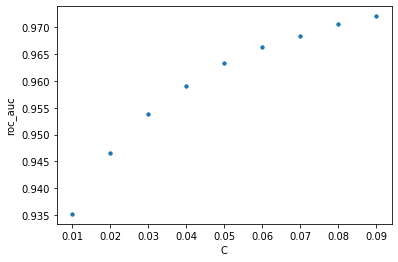

In [20]:
#6. Gráfico de C vs. ROC AUC
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

- Eje X (*C*): Este parámetro controla la fuerza de la regularización en la regresión logística. Valores más bajos de 
*C* indican más regularización (lo que puede prevenir el sobreajuste pero también puede causar subajuste si es demasiado alto), y valores más altos indican menos regularización (lo que puede capturar mejor las relaciones complejas en los datos pero también puede llevar al sobreajuste).


- Eje Y (ROC AUC): El área bajo la curva ROC (ROC AUC) es una métrica de rendimiento que mide la capacidad del modelo para clasificar correctamente las clases positivas y negativas. Un valor más alto es mejor, con 1.0 representando un modelo perfecto.

Se predicen las probabilidad en el conjunto de Test y se calcula la métrica **ROC AUC**:

In [21]:
#7. Predicciones con el mejor modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
print("ROC AUC score (con ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:,1]))

ROC AUC score (con ajuste): 0.9495192307692307


**Aquí hay varias razones y consideraciones que podrían explicar por qué el ROC AUC es más bajo en el conjunto de prueba:**

1. Sobreajuste durante la Optimización de Hiperparámetros:

Aunque la búsqueda de hiperparámetros tiene como objetivo encontrar la configuración que generaliza mejor, a veces puede resultar en un modelo que está sobreajustado a las particularidades del conjunto de entrenamiento. Este sobreajuste puede no ser evidente durante la validación cruzada pero puede manifestarse cuando el modelo se evalúa en nuevos datos (conjunto de prueba).


2. Variabilidad de los Datos de Prueba:

El conjunto de prueba puede tener características ligeramente diferentes o puede incluir variaciones no capturadas completamente durante el entrenamiento. Esto puede deberse a la distribución de los datos, la presencia de outliers, o simplemente diferencias en las relaciones subyacentes que no fueron totalmente aprendidas por el modelo.


3. Diferencias en la Distribución de las Clases:

Si la distribución de las clases en el conjunto de prueba es diferente de la del conjunto de entrenamiento (incluso después del uso de técnicas como SMOTE), esto puede afectar el rendimiento del modelo. Por ejemplo, un desequilibrio más pronunciado en el conjunto de prueba podría influir en la capacidad del modelo para clasificar correctamente las instancias de clases minoritarias.


4. Estabilidad del Modelo:

Algunos modelos pueden ser sensibles a pequeñas variaciones en los datos de entrada, lo que podría llevar a resultados diferentes al cambiar de un conjunto de datos a otro. La regularización y la selección de hiperparámetros ayudan a controlar esto, pero no siempre eliminan completamente la variabilidad.

## 1.2. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

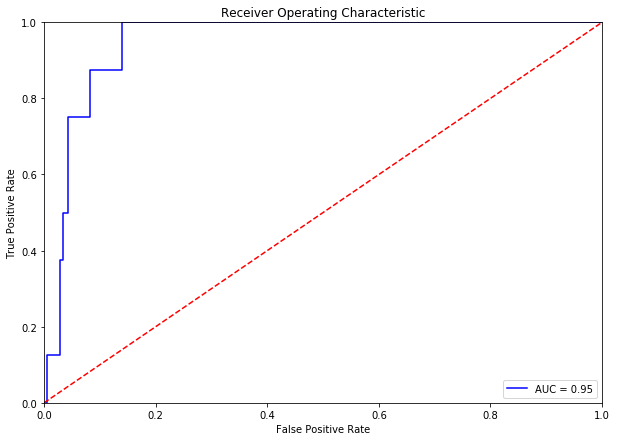

In [22]:
#8. Curva ROC
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- Curva ROC (línea azul): 
Muestra la relación entre TPR y FPR. El TPR (también conocido como sensibilidad o recall) está en el eje Y y representa la proporción de positivos reales que se identificaron correctamente como tales por el modelo. El FPR está en el eje X y representa la proporción de negativos reales que fueron incorrectamente clasificados como positivos.


- Línea diagonal roja (línea de no discriminación): 
Esta línea representa una estrategia de clasificación aleatoria. Un clasificador perfecto se ubicaría en la esquina superior izquierda del gráfico, con una TPR de 1 y una FPR de 0.


- Área bajo la curva (AUC): 
El área bajo la curva ROC (AUC) proporcionada en la leyenda como AUC = 0.90 indica la capacidad del modelo para discriminar entre las clases positivas y negativas. El valor de AUC varía de 0.5 a 1, donde 0.5 indica un modelo no mejor que una clasificación aleatoria y 1 indica un modelo perfecto. Un AUC de 0.90 sugiere un muy buen desempeño del modelo en general.

Se representan los histogramas de probabilidad de las predicciones en test:

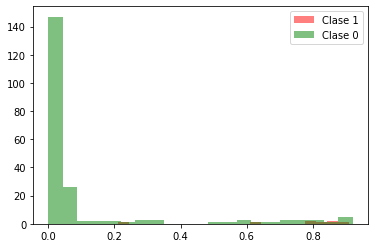

In [23]:
#9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density = 0)

**Histogramas de Probabilidad:**

- Clase Positiva (1): Representada por el color rojo. Muestra la distribución de las probabilidades predichas por el modelo para los casos que son verdaderamente positivos (personas clasificadas correctamente como 'suicidal').


- Clase Negativa (0): Representada por el color verde. Muestra la distribución de las probabilidades para los casos que son verdaderamente negativos.


**Ejes:**

- Eje X: Muestra el rango de probabilidades predichas (de 0 a 1).


- Eje Y: Muestra el recuento de casos en cada bin del histograma.

#### Cálculo de la sensibilidad:

In [24]:
#10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

df_sensibilidad

,Umbral,Sensibilidad
0,0.1,1.000
1,0.2,1.000
2,0.3,0.875
3,0.4,0.875
4,0.5,0.875
5,0.6,0.875
6,0.7,0.750
7,0.8,0.500
8,0.9,0.125


#### Cálculo de la precisión:

In [25]:
#11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)

df_precisiones = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

df_precisiones

,Umbral,Precisión
0,0.1,0.186047
1,0.2,0.216216
2,0.3,0.218750
3,0.4,0.241379
4,0.5,0.250000
5,0.6,0.291667
6,0.7,0.285714
7,0.8,0.307692
8,0.9,0.250000


#### Umbral por defecto.

In [26]:
# 12. Matriz de confusión y métricas con el umbral por defecto
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[187  21]
 [  1   7]]

Accuracy	0.9
Sensitividad	0.88
Precisión	0.25


#### Validación cruzada y ajuste de umbral.

In [27]:
from sklearn.model_selection import cross_val_predict

In [28]:
def evaluate_model_with_cv(model, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    y_probs = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y, y_probs)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
    
    roc_auc = auc(fpr, tpr)
    conf_matrix = confusion_matrix(y, y_pred_optimal)
    accuracy = metrics.accuracy_score(y, y_pred_optimal)
    recall = metrics.recall_score(y, y_pred_optimal)
    precision = metrics.precision_score(y, y_pred_optimal)
    
    print('Umbral óptimo (validación cruzada):', optimal_threshold)
    print('ROC AUC de validación cruzada:', roc_auc)
    print('Matriz de confusión (validación cruzada):\n', conf_matrix)
    print("\nAccuracy (validación cruzada):\t{}".format(round(accuracy, 2)))
    print("Sensitividad (validación cruzada):\t{}".format(round(recall, 2)))
    print(u"Precisión (validación cruzada):\t{}".format(round(precision, 2)))

In [29]:
#13. Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.7172852759202158
ROC AUC de validación cruzada: 0.9750013191142587
Matriz de confusión (validación cruzada):
 [[376  37]
 [  6 407]]

Accuracy (validación cruzada):	0.95
Sensitividad (validación cruzada):	0.99
Precisión (validación cruzada):	0.92


# 2. Modelo KNN.

In [30]:
from sklearn.neighbors import KNeighborsClassifier

#### Ajuste y predicción del modelo:

In [31]:
# 1. Entrenamiento del modelo
modelo_KNN = KNeighborsClassifier()
# Ajustar el modelo KNN al conjunto de entrenamiento balanceado
modelo_KNN.fit(X_train_sm, y_train_sm)

KNeighborsClassifier()

In [32]:
# 2. Predicciones de prueba
y_test_pred_prob = modelo_KNN.predict_proba(X_test_scaled)
print("ROC AUC score (sin ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:,1]))

ROC AUC score (sin ajuste): 0.9155649038461539


## 2.2. Optimización de parámetros

In [33]:
# 3. GridSearch para hiperparámetros con validación cruzada
parametros = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan']
}
modelo_gs = GridSearchCV(modelo_KNN, param_grid=parametros, cv=5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [34]:
# 4. Mejores parámetros y score de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC mejorado: {}".format(round(modelo_gs.best_score_,2)))

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'} 
ROC AUC mejorado: 1.0


In [35]:
# 5. Resultados de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

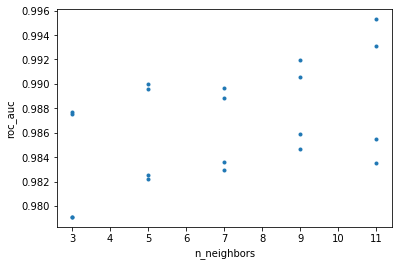

In [36]:
# 6. Gráfico de n_neighbors vs. roc_auc
plt.figure()
plt.xlabel('n_neighbors')
plt.ylabel('roc_auc')
_ = plt.plot(df_search['param_n_neighbors'], df_search['mean_test_score'], '.')

In [37]:
# 7. Predicciones con el mejor modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
print("ROC AUC Score (con ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (con ajuste): 0.9161658653846154


## 2.2. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

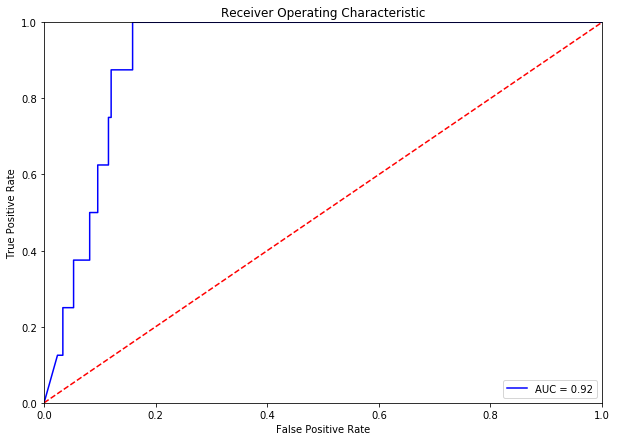

In [38]:
# 8. Curva ROC
preds = y_test_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

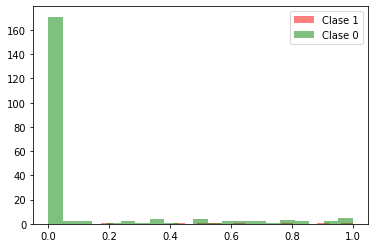

In [39]:
# 9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

#### Cálculo de la sensibilidad:

In [40]:
# 10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

# Imprimir la tabla
df_sensibilidad

,Umbral,Sensibilidad
0,0.1,1.000
1,0.2,0.875
2,0.3,0.875
3,0.4,0.875
4,0.5,0.625
5,0.6,0.500
6,0.7,0.375
7,0.8,0.250
8,0.9,0.125


#### Cálculo de la precisión:

In [41]:
#11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)
# Crear un DataFrame a partir del diccionario
df_precision = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

# Imprimir la tabla
df_precision

,Umbral,Precisión
0,0.1,0.186047
1,0.2,0.179487
2,0.3,0.189189
3,0.4,0.218750
4,0.5,0.172414
5,0.6,0.181818
6,0.7,0.166667
7,0.8,0.166667
8,0.9,0.125000


#### Umbral por defecto

In [42]:
# 12. Matriz de confusión y métricas con el umbral por defecto.
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[184  24]
 [  3   5]]

Accuracy	0.88
Sensitividad	0.62
Precisión	0.17


#### Validación cruzada y ajuste de umbral.

In [43]:
#13. Validación cruzada con ajuste de umbral
# Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.8485634082278083
ROC AUC de validación cruzada: 0.9924634605350328
Matriz de confusión (validación cruzada):
 [[400  13]
 [  3 410]]

Accuracy (validación cruzada):	0.98
Sensitividad (validación cruzada):	0.99
Precisión (validación cruzada):	0.97


# 3. Modelo Árboles de Decisión.

In [44]:
from sklearn.tree import DecisionTreeClassifier

#### Ajuste y predicción del modelo:

In [45]:
# 1. Entrenamiento del modelo
modelo_DT = DecisionTreeClassifier()
modelo_DT.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

In [46]:
# 2. Predicciones de prueba
y_test_pred_prob = modelo_DT.predict_proba(X_test_scaled)
print("ROC AUC Score (sin ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (sin ajuste): 0.6754807692307693


## 3.1. Optimización de parámetros

In [47]:
# 3. GridSearch para hiperparámetros con validación cruzada
parametros = {"max_depth": [3, 5, 7, 9, 11], 
              "min_samples_split": [2, 5, 10, 20]}
modelo_gs = GridSearchCV(modelo_DT, param_grid=parametros, cv=5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='roc_auc')

In [48]:
# 4. Mejores parámetros y score de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_, 2)))

{'max_depth': 9, 'min_samples_split': 20} 
ROC AUC: 0.99


In [49]:
# 5. Resultados de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

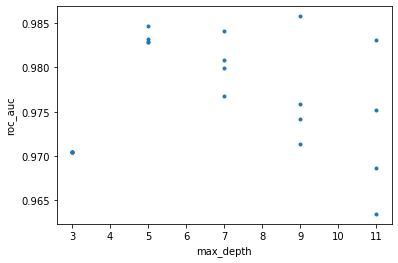

In [50]:
# 6. Gráfico de max_depth vs. roc_auc
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
_ = plt.plot(df_search['param_max_depth'], df_search['mean_test_score'], '.')

In [51]:
# 7. Predicciones con el mejor modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
print("ROC AUC Score (con ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (con ajuste): 0.844951923076923


## 3.2. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

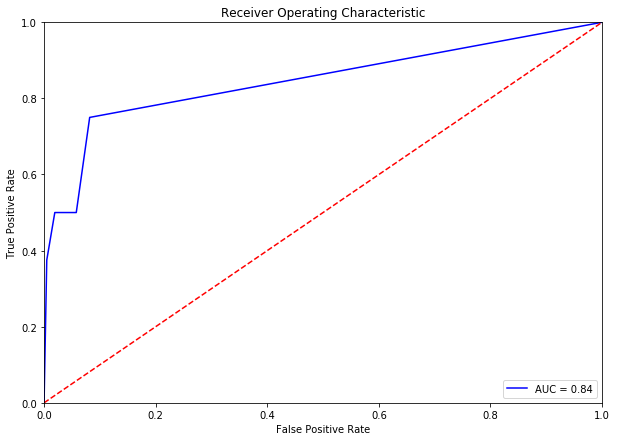

In [52]:
# 8. Curva ROC
preds = y_test_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

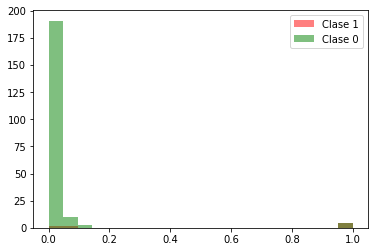

In [53]:
# 9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

#### Cálculo de la sensibilidad:

In [54]:
# 10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

# Imprimir la tabla
df_sensibilidad

,Umbral,Sensibilidad
0,0.1,0.5
1,0.2,0.5
2,0.3,0.5
3,0.4,0.5
4,0.5,0.5
5,0.6,0.5
6,0.7,0.5
7,0.8,0.5
8,0.9,0.5


#### Cálculo de la precisión:

In [55]:
# 11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_precision = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

# Imprimir la tabla
df_precision

,Umbral,Precisión
0,0.1,0.363636
1,0.2,0.500000
2,0.3,0.500000
3,0.4,0.500000
4,0.5,0.500000
5,0.6,0.500000
6,0.7,0.500000
7,0.8,0.500000
8,0.9,0.500000


#### Cálculo de las métricas accuracy, sensibilidad, predicción y la matriz de confusión con el umbral por defecto

In [56]:
# 12. Matriz de confusión y métricas con el umbral por defecto
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[204   4]
 [  4   4]]

Accuracy	0.96
Sensitividad	0.5
Precisión	0.5


#### Validación cruzada y umbral óptimo

In [57]:
#13. Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.6666666666666666
ROC AUC de validación cruzada: 0.9883302358576295
Matriz de confusión (validación cruzada):
 [[400  13]
 [ 13 400]]

Accuracy (validación cruzada):	0.97
Sensitividad (validación cruzada):	0.97
Precisión (validación cruzada):	0.97


# 4. Random forest.

In [58]:
from sklearn.ensemble import RandomForestClassifier

#### Ajuste y predicción del modelo:

In [59]:
# 1. Entrenamiento del modelo
modelo_RF = RandomForestClassifier()
modelo_RF.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [60]:
# 2. Predicciones de prueba
y_test_pred_prob = modelo_RF.predict_proba(X_test_scaled)
print("ROC AUC Score (sin ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (sin ajuste): 0.9441105769230769


## 4.1. Optimización de parámetros

In [61]:
# 3. GridSearch para hiperparámetros con validación cruzada
parametros = {"n_estimators": [50, 100, 200], 
              "max_depth": [3, 5, 7, 9, 11], 
              "min_samples_split": [2, 5, 10, 20]}
modelo_gs = GridSearchCV(modelo_RF, param_grid=parametros, cv=5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [62]:
# 4. Mejores parámetros y score de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_, 2)))

{'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 100} 
ROC AUC: 1.0


In [63]:
# 5. Resultados de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

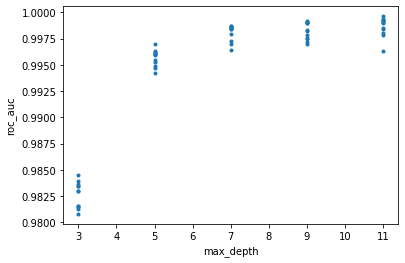

In [64]:
# 6. Gráfico de max_depth vs. roc_auc
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
_ = plt.plot(df_search['param_max_depth'], df_search['mean_test_score'], '.')

In [65]:
# 7. Predicciones con el mejor modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
print("ROC AUC Score (con ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (con ajuste): 0.9543269230769231


## 4.3. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

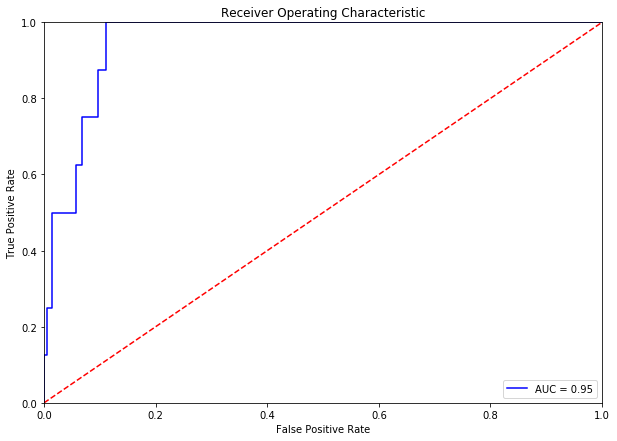

In [66]:
# 8. Curva ROC
preds = y_test_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

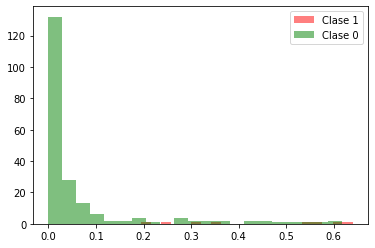

In [67]:
# 9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

#### Cálculo de la sensibilidad y precisiones:

In [68]:
# 10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

# Imprimir la tabla
df_sensibilidad

,Umbral,Sensibilidad
0,0.1,1.000
1,0.2,0.875
2,0.3,0.750
3,0.4,0.500
4,0.5,0.500
5,0.6,0.250
6,0.7,0.000
7,0.8,0.000
8,0.9,0.000


In [69]:
# 11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_precision = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

# Imprimir la tabla
df_precision

,Umbral,Precisión
0,0.1,0.205128
1,0.2,0.241379
2,0.3,0.300000
3,0.4,0.285714
4,0.5,0.444444
5,0.6,0.500000
6,0.7,0.000000
7,0.8,0.000000
8,0.9,0.000000


In [70]:
# 12. Matriz de confusión y métricas con el umbral por defecto
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[203   5]
 [  4   4]]

Accuracy	0.96
Sensitividad	0.5
Precisión	0.44


In [71]:
# 13. Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.6728101916783544
ROC AUC de validación cruzada: 0.999056100463742
Matriz de confusión (validación cruzada):
 [[412   1]
 [  7 406]]

Accuracy (validación cruzada):	0.99
Sensitividad (validación cruzada):	0.98
Precisión (validación cruzada):	1.0


# 5. Modelo XGBoost.

In [72]:
from xgboost import XGBClassifier

#### Ajuste y predicción del modelo:

In [73]:
# 1. Entrenamiento del modelo
modelo_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
modelo_XGB.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [74]:
# 2. Predicciones de prueba
y_test_pred_prob = modelo_XGB.predict_proba(X_test_scaled)
print("ROC AUC Score (sin ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (sin ajuste): 0.9543269230769231


## 5.1. Optimización de parámetros

In [75]:
# 3. GridSearch para hiperparámetros con validación cruzada
parametros = {"n_estimators": [50, 100, 200], 
              "max_depth": [3, 5, 7, 9, 11], 
              "learning_rate": [0.01, 0.1, 0.2]}
modelo_gs = GridSearchCV(modelo_XGB, param_grid=parametros, cv=5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0, gpu_id=-1,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                    

In [76]:
# 4. Mejores parámetros y score de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_, 2)))

{'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 200} 
ROC AUC: 1.0


In [77]:
# 5. Resultados de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

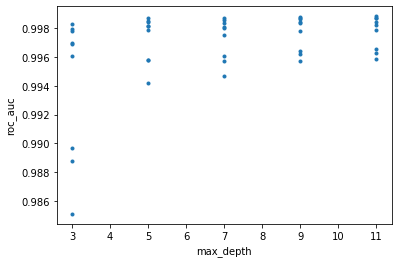

In [78]:
# 6. Gráfico de max_depth vs. roc_auc
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
_ = plt.plot(df_search['param_max_depth'], df_search['mean_test_score'], '.')

In [79]:
# 7. Predicciones con el mejor modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
print("ROC AUC Score (con ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (con ajuste): 0.9501201923076923


## 5.2. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

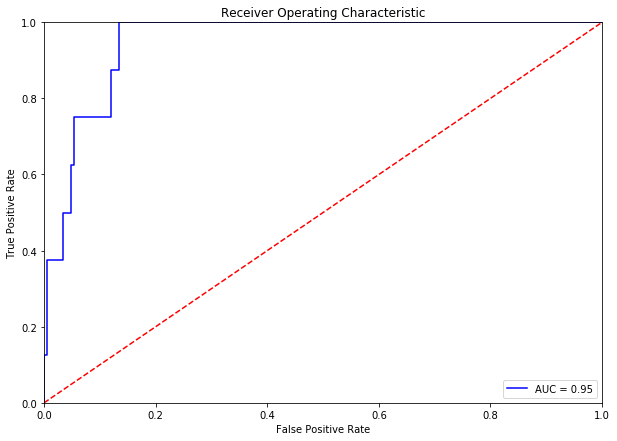

In [80]:
# 8. Curva ROC
preds = y_test_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

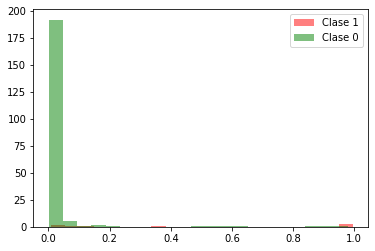

In [81]:
# 9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

#### Cálculo de la sensibilidad:

In [82]:
# 10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

# Imprimir la tabla
df_sensibilidad

,Umbral,Sensibilidad
0,0.1,0.625
1,0.2,0.500
2,0.3,0.500
3,0.4,0.375
4,0.5,0.375
5,0.6,0.375
6,0.7,0.375
7,0.8,0.375
8,0.9,0.375


#### Cálculo de la precisión:

In [83]:
# 11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_precision = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

# Imprimir la tabla
df_precision

,Umbral,Precisión
0,0.1,0.312500
1,0.2,0.333333
2,0.3,0.363636
3,0.4,0.300000
4,0.5,0.300000
5,0.6,0.428571
6,0.7,0.500000
7,0.8,0.500000
8,0.9,0.750000


#### Cálculo de las métricas accuracy, sensibilidad, predicción y la matriz de confusión con el umbral 0,3

In [84]:
# 12. Matriz de confusión y métricas con el umbral por defecto
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[201   7]
 [  5   3]]

Accuracy	0.94
Sensitividad	0.38
Precisión	0.3


In [85]:
# 13. Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.80777556
ROC AUC de validación cruzada: 0.9985812193305935
Matriz de confusión (validación cruzada):
 [[410   3]
 [ 12 401]]

Accuracy (validación cruzada):	0.98
Sensitividad (validación cruzada):	0.97
Precisión (validación cruzada):	0.99


# 6. Modelo Máquinas Soporte Vectorial.

In [86]:
from sklearn.svm import SVC

#### Ajuste y predicción del modelo:

In [87]:
# 1. Entrenamiento del modelo
modelo_SVM = SVC(probability=True)
modelo_SVM.fit(X_train_sm, y_train_sm)

SVC(probability=True)

In [88]:
# 2. Predicciones de prueba
y_test_pred_prob = modelo_SVM.predict_proba(X_test_scaled)
print("ROC AUC Score (sin ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (sin ajuste): 0.9368990384615385


In [89]:
# Revisar distribución de probabilidades
print("Distribución de probabilidades:\n", pd.Series(y_test_pred_prob[:, 1]).describe())

Distribución de probabilidades:
 count    2.160000e+02
mean     4.681245e-02
std      1.897918e-01
min      1.000000e-07
25%      1.979444e-06
50%      4.643968e-06
75%      1.071196e-05
max      9.891018e-01
dtype: float64


## 6.1. Optimización de parámetros

In [90]:
# 3. GridSearch para hiperparámetros con validación cruzada
parametros = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
modelo_gs = GridSearchCV(SVC(probability=True), param_grid=parametros, cv=5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')

In [91]:
# 4. Mejores parámetros y score de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_, 2)))

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} 
ROC AUC: 1.0


In [92]:
# 5. Resultados de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

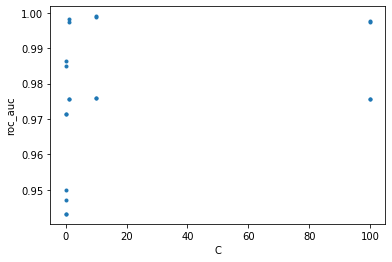

In [93]:
# 6. Gráfico de C vs. roc_auc
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot(df_search['param_C'], df_search['mean_test_score'], '.')

In [94]:
# 7. Predicciones con el mejor modelo
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
print("ROC AUC Score (con ajuste):", metrics.roc_auc_score(y_test, y_test_pred_prob[:, 1]))

ROC AUC Score (con ajuste): 0.8299278846153847


In [95]:
# Revisar distribución de probabilidades después del ajuste
print("Distribución de probabilidades después del ajuste:\n", pd.Series(y_test_pred_prob[:, 1]).describe())

Distribución de probabilidades después del ajuste:
 count    2.160000e+02
mean     3.065087e-02
std      1.544850e-01
min      1.000000e-07
25%      1.757443e-06
50%      1.434748e-05
75%      5.099834e-05
max      9.928028e-01
dtype: float64


## 6.2. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

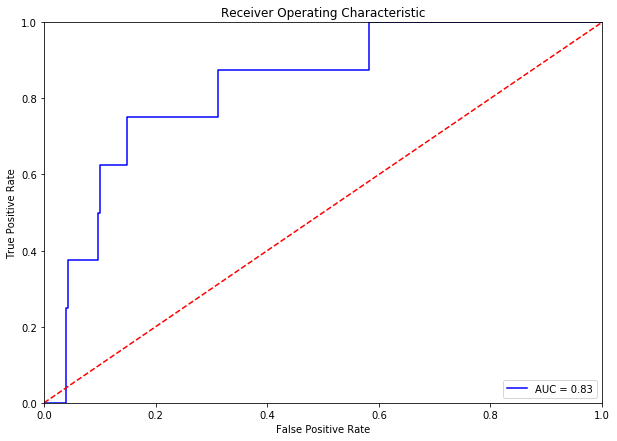

In [96]:
# 8. Curva ROC
preds = y_test_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

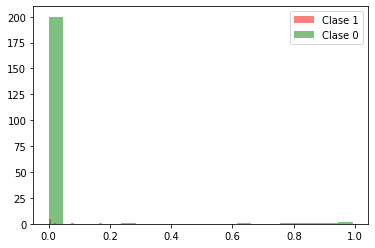

In [97]:
# 9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

#### Cálculo de la sensibilidad:

In [98]:
# 10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = (y_test_pred_prob[:, 1] > umbral).astype(int)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

# Imprimir la tabla
df_sensibilidad

,Umbral,Sensibilidad
0,0.1,0.125
1,0.2,0.000
2,0.3,0.000
3,0.4,0.000
4,0.5,0.000
5,0.6,0.000
6,0.7,0.000
7,0.8,0.000
8,0.9,0.000


#### Cálculo de la precisión:

In [99]:
# 11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)

# Crear un DataFrame a partir del diccionario
df_precision = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

# Imprimir la tabla
df_precision

,Umbral,Precisión
0,0.1,0.111111
1,0.2,0.000000
2,0.3,0.000000
3,0.4,0.000000
4,0.5,0.000000
5,0.6,0.000000
6,0.7,0.000000
7,0.8,0.000000
8,0.9,0.000000


#### Cálculo de las métricas accuracy, sensibilidad, predicción y la matriz de confusión con el umbral 0,2

In [100]:
# 12. Matriz de confusión y métricas con el umbral por defecto
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[201   7]
 [  8   0]]

Accuracy	0.93
Sensitividad	0.0
Precisión	0.0


In [101]:
# 13. Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.8448387065615507
ROC AUC de validación cruzada: 0.9984346510796217
Matriz de confusión (validación cruzada):
 [[410   3]
 [  1 412]]

Accuracy (validación cruzada):	1.0
Sensitividad (validación cruzada):	1.0
Precisión (validación cruzada):	0.99


# 7. Modelo Redes Neuronales

#### Ajuste y predicción del modelo:

In [102]:
# 1. Entrenamiento del modelo
modelo_nn = MLPClassifier()
modelo_nn.fit(X_train_sm, y_train_sm)

MLPClassifier()

In [103]:
# 2. Predicciones de prueba
y_test_pred_prob = modelo_nn.predict_proba(X_test_scaled)
print("ROC AUC inicial:", metrics.roc_auc_score(y_test, y_test_pred_prob[:,1]))

ROC AUC inicial: 0.9435096153846154


## 7.1. Optimización de parámetros

In [104]:
# 3. GridSearch para hiperparámetros con validación cruzada
parametros = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ["constant", "adaptive"]
}

modelo_gs = GridSearchCV(modelo_nn, param_grid=parametros, cv=5, scoring='roc_auc')
modelo_gs.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='roc_auc')

In [105]:
# 4. Mejores parámetros y resultado de ROC AUC
print(modelo_gs.best_params_, "\nROC AUC mejorado: {}".format(round(modelo_gs.best_score_, 2)))

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'} 
ROC AUC mejorado: 1.0


In [106]:
# 5. Resultado de la búsqueda
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

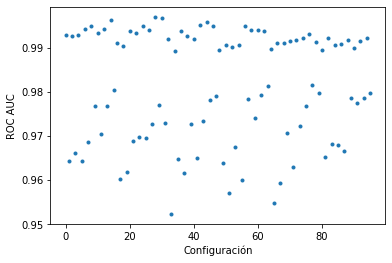

In [107]:
# 6. Gráfico de C vs. ROC AUC
plt.figure()
plt.xlabel('Configuración')
plt.ylabel('ROC AUC')
plt.plot(range(len(df_search)), df_search['mean_test_score'], '.')

In [108]:
# 7. Predicciones con el mejor modelo.
y_test_pred_prob = modelo_gs.predict_proba(X_test_scaled)
metrics.roc_auc_score(y_test, y_test_pred_prob[:,1])

0.8804086538461537

## 7.2. Representación de las probabilidades:

Se representa la curva ROC de las predicciones en test:

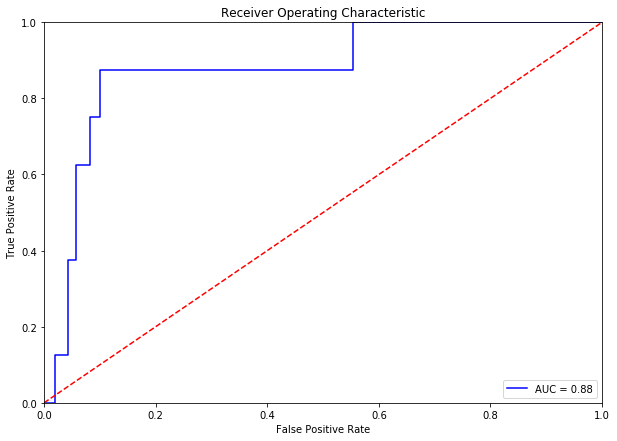

In [109]:
# 8. Curva ROC
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Dibujar ROC
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

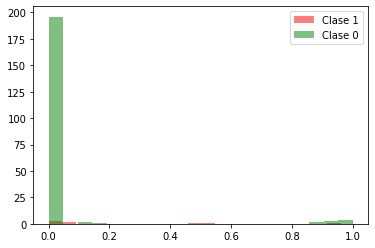

In [110]:
# 9. Distribución de probabilidades
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

#### Cálculo de la sensibilidad:

In [111]:
#10. Sensibilidad para diferentes umbrales
sensibilidad = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensibilidad[umbral] = metrics.recall_score(y_test, y_umbralizadas)

df_sensibilidad = pd.DataFrame(list(sensibilidad.items()), columns=['Umbral', 'Sensibilidad'])

df_sensibilidad

,Umbral,Sensibilidad
0,0.1,0.375
1,0.2,0.375
2,0.3,0.375
3,0.4,0.375
4,0.5,0.250
5,0.6,0.125
6,0.7,0.125
7,0.8,0.125
8,0.9,0.125


#### Cálculo de la precisión:

In [112]:
#11. Precisión para diferentes umbrales
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(y_test, y_umbralizadas)

df_precisiones = pd.DataFrame(list(precisiones.items()), columns=['Umbral', 'Precisión'])

df_precisiones

,Umbral,Precisión
0,0.1,0.200000
1,0.2,0.250000
2,0.3,0.250000
3,0.4,0.250000
4,0.5,0.181818
5,0.6,0.100000
6,0.7,0.100000
7,0.8,0.100000
8,0.9,0.125000


#### Cálculo de las métricas accuracy, sensibilidad, predicción y la matriz de confusión con el umbral 0,2

In [113]:
# 12. Matriz de confusión y métricas con el umbral por defecto
optimal_threshold = 0.5
y_umbralizadas = 1 * (y_test_pred_prob[:, 1] > optimal_threshold)
print(u"Matriz de confusión\n", metrics.confusion_matrix(y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbralizadas), 2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbralizadas), 2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbralizadas), 2)))

Matriz de confusión
 [[199   9]
 [  6   2]]

Accuracy	0.93
Sensitividad	0.25
Precisión	0.18


In [114]:
#13. Evalúa el modelo con validación cruzada y ajuste de umbral utilizando los datos de entrenamiento
evaluate_model_with_cv(modelo_gs.best_estimator_, X_train_sm, y_train_sm, cv=5)

Umbral óptimo (validación cruzada): 0.950084275218093
ROC AUC de validación cruzada: 0.9957905598320914
Matriz de confusión (validación cruzada):
 [[406   7]
 [  1 412]]

Accuracy (validación cruzada):	0.99
Sensitividad (validación cruzada):	1.0
Precisión (validación cruzada):	0.98
